!pip install sklearn

# Part-of-speech tagging

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer




### Define constant variables

In [2]:
train_path = './Dataset/train/'# Should we use: os.path.join(os.getcwd(), "OriginalDataset")
val_path = './Dataset/val/'
test_path = './Dataset/test/'
dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")
original_path = dataset_folder +'/dependency_treebank/'

embedding_dimension = 50


### Download dataste

In [3]:
import urllib.request  #  download files
import zipfile  #  unzip files

def download_dataset():
    dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

    dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
        print("Successful download")

    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Successful extraction")

In [4]:
download_dataset()

Successful extraction


### Split dataset

In [5]:
def split_dataset(train_path, val_path, test_path, original_path):
    if not os.path.exists(train_path):
        print("making directory")
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    original_dataset = os.listdir(original_path)
    
    original_dataset.sort()
    org_train = original_dataset[0:100]
    org_val = original_dataset[100:150]
    org_test = original_dataset[150:]

    for f in org_train:
        os.rename(original_path+f, train_path+f)
    for f in org_val:
        os.rename(original_path+f, val_path+f)
    for f in org_test:
        os.rename(original_path+f, test_path+f)
    print("Successful spilt")
        

In [6]:
split_dataset(train_path, val_path, test_path, original_path)


Successful spilt


### Create dataframe

In [7]:
def create_dataframe(dataset_path: str):
    dataframe_rows = []
    documents = os.listdir(dataset_path)
    for document in documents:
        path = os.path.join(dataset_path, document)
        with open(path, 'r') as f:
            a = [[x for x in ln.split()] for ln in f]
        #---------------For splitting on sentence-------------------#
        sentence = []
        sentence_tag = []
        for x in a:
            if x!=[]:
                sentence.append(x[0])
                sentence_tag.append(x[1])
            else:
                dataframe_row = {
                    "text": sentence,
                    "POS": sentence_tag
                }
                sentence = []
                sentence_tag = []
                dataframe_rows.append(dataframe_row)
        #----------------------------------------------------------#
        #------------------To split on document--------------------#
        """
        a2 = [x for x in a if x != []] # OBS! Removing all empty lines in file so we can make an array
        arr = np.array(a2)
        text = list(arr[:, 0])
        tagg = list(arr[:, 1])
        #POStuple =  [tagg[x] for x in range(len(text))] #[(text[x], tagg[x]) for x in range(len(text))]
        document_id = int(document[4:8])
        dataframe_row = {
            "document_id": document_id,
            "text": text,
            "POS": tagg
        }
        dataframe_rows.append(dataframe_row)"""
        #----------------------------------------------------------#
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text", "POS"]]

    return df

In [8]:
df_train = create_dataframe(train_path)
df_val = create_dataframe(val_path)
df_test = create_dataframe(test_path)

df_train

,text,POS
0,"[In, reference, to, your, Oct., 9, page-one, a...","[IN, NN, TO, PRP$, NNP, CD, NN, NN, ``, NNP, N..."
1,"[In, part, ,, this, may, reflect, the, fact, t...","[IN, NN, ,, DT, MD, VB, DT, NN, IN, ``, PRP, V..."
2,"[Among, professionals, ,, 76, %, have, a, favo...","[IN, NNS, ,, CD, NN, VBP, DT, JJ, NN, IN, PRP$..."
3,"[While, a, quarter, of, black, voters, disappr...","[IN, DT, NN, IN, JJ, NNS, VBP, IN, NNP, NNP, P..."
4,"[The, statistics, imply, that, three-quarters,...","[DT, NNS, VBP, IN, NNS, IN, NNS, VBP, IN, NNP,..."
...,...,...
1858,"[He, said, authors, of, Scoring, High, ``, scr...","[PRP, VBD, NNS, IN, NNP, NNP, ``, RB, VBP, '',..."
1859,"[When, Scoring, High, first, came, out, in, 19...","[WRB, NNP, NNP, RB, VBD, RB, IN, CD, ,, PRP, V..."
1860,"[McGraw-Hill, was, outraged, .]","[NNP, VBD, JJ, .]"
1861,"[In, a, 1985, advisory, to, educators, ,, McGr...","[IN, DT, CD, NN, TO, NNS, ,, NNP, VBD, NNP, NN..."


### Embed the words using GloVe embedding

#### Load glove model

In [9]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [10]:
embedding_model = load_embedding_model(embedding_dimension)

### Make tokenizer REMOVE THIS PART

In [11]:
"""# OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.
# The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. 
word_tokenizer_train2 = Tokenizer()

# UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry
word_tokenizer_train2.fit_on_texts(embedding_model.index_to_key) 
word_tokenizer_train2.fit_on_texts(df_train["text"])

x_encoded_train = word_tokenizer_train2.texts_to_sequences(df_train["text"])"""

'# OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.\n# The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. \nword_tokenizer_train2 = Tokenizer()\n\n# UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry\nword_tokenizer_train2.fit_on_texts(embedding_model.index_to_key) \nword_tokenizer_train2.fit_on_texts(df_train["text"])\n\nx_encoded_train = word_tokenizer_train2.texts_to_sequences(df_train["text"])'

In [12]:
"""tag_tokenizer_train2 = Tokenizer()

tag_tokenizer_train2.fit_on_texts(df_train["POS"])
y_encoded_train = tag_tokenizer_train2.texts_to_sequences(df_train["POS"])"""

'tag_tokenizer_train2 = Tokenizer()\n\ntag_tokenizer_train2.fit_on_texts(df_train["POS"])\ny_encoded_train = tag_tokenizer_train2.texts_to_sequences(df_train["POS"])'

### NEW WAY TO Make tokenizer

In [13]:
def make_tokenizer(*vocabulary):
    # OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.
    # The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. 
    tokenizer = Tokenizer()
    
    # UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry
    for v in vocabulary:
        tokenizer.fit_on_texts(v)
    return tokenizer 


In [14]:
word_tokenizer = make_tokenizer(df_train["text"], df_val["text"], df_test["text"])
tag_tokenizer = make_tokenizer(df_train["POS"])

### Encode X and Y

In [15]:
x_encoded_train = word_tokenizer.texts_to_sequences(df_train["text"])
y_encoded_train = tag_tokenizer.texts_to_sequences(df_train["POS"])

In [16]:
x_encoded_val = word_tokenizer.texts_to_sequences(df_val["text"])
y_encoded_val = tag_tokenizer.texts_to_sequences(df_val["POS"])

In [17]:
x_encoded_test = word_tokenizer.texts_to_sequences(df_test["text"])
y_encoded_test = tag_tokenizer.texts_to_sequences(df_test["POS"])


### Pad encoded sequences

In [18]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len)
    return padded_idxs

In [19]:
def find_max_length(seqs):
    max_len = 0
    for seq in seqs:
        if len(seq) > max_len:
            max_len = len(seq)
    return max_len

In [20]:
x_padded_train = pad_idx_seqs(x_encoded_train, find_max_length(x_encoded_train))
y_padded_train = pad_idx_seqs(y_encoded_train, find_max_length(y_encoded_train))

In [21]:
x_padded_val = pad_idx_seqs(x_encoded_val, find_max_length(x_encoded_train))
y_padded_val = pad_idx_seqs(y_encoded_val, find_max_length(y_encoded_train))

In [22]:
x_padded_test = pad_idx_seqs(x_encoded_test, find_max_length(x_encoded_test))
y_padded_test = pad_idx_seqs(y_encoded_test, find_max_length(y_encoded_test))

# NEW METHODE TO GET WORD TO INDX

In [23]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

word2idx = word_tokenizer.word_index
idx2word = word_tokenizer.index_word

In [24]:
tag2idx = tag_tokenizer.word_index
idx2tag = tag_tokenizer.index_word
len(tag2idx)

45

In [48]:
TAG_VOCABULARY_SIZE = len(tag2idx) + 1

### Create embedding matrix

In [26]:
# OBS Computes the OOV with random embeddings
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix

def expand_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, old_embedding_matrix):
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dimension), dtype=np.float32)
    embedding_matrix[0:len(old_embedding_matrix)] = old_embedding_matrix
    
    for word, idx in word_to_idx.items():
        if idx >= len(old_embedding_matrix):
            try:
                embedding_vector = embedding_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
                
            embedding_matrix[idx] = embedding_vector
    
    return embedding_matrix                                

In [27]:
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, word2idx)

In [28]:
embedding_matrix.shape

(10718, 50)

#### Define x train and y train

In [29]:
x_train = x_padded_train
y_train = to_categorical(y_padded_train)

In [61]:
x_val = x_padded_val
y_val = to_categorical(y_padded_val, num_classes=TAG_VOCABULARY_SIZE)

In [63]:
x_test = x_padded_test
y_test = to_categorical(y_padded_test)

### Define plotting functions

In [83]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

### Create baseline model

##### two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top


https://www.kaggle.com/tanyadayanand/pos-tagging-using-rnn/notebook

Not sure about the parameters etc.. but at least it works to train the model

In [64]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = True
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [65]:
baseline_model = create_baseline_model(64, 'softmax')
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_3 (Bidirectio  (None, 249, 128)         58880     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 249, 46)           5934      
                                                                 
Total params: 600,714
Trainable params: 600,714
Non-trainable params: 0
_________________________________________________________________


In [71]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=25,  epochs=10)

Epoch 1/10
75/75 [==============================] - 19s 203ms/step - loss: 0.0081 - mae: 0.0172 - acc: 0.8999 - val_loss: 0.0021 - val_mae: 0.0046 - val_acc: 0.9147
Epoch 2/10
75/75 [==============================] - 12s 162ms/step - loss: 0.0020 - mae: 0.0045 - acc: 0.9181 - val_loss: 0.0020 - val_mae: 0.0043 - val_acc: 0.9235
Epoch 3/10
75/75 [==============================] - 14s 185ms/step - loss: 0.0019 - mae: 0.0042 - acc: 0.9287 - val_loss: 0.0018 - val_mae: 0.0040 - val_acc: 0.9337
Epoch 4/10
75/75 [==============================] - 12s 163ms/step - loss: 0.0017 - mae: 0.0038 - acc: 0.9389 - val_loss: 0.0016 - val_mae: 0.0035 - val_acc: 0.9460
Epoch 5/10
75/75 [==============================] - 14s 191ms/step - loss: 0.0014 - mae: 0.0032 - acc: 0.9503 - val_loss: 0.0013 - val_mae: 0.0030 - val_acc: 0.9510
Epoch 6/10
75/75 [==============================] - 14s 182ms/step - loss: 0.0012 - mae: 0.0028 - acc: 0.9547 - val_loss: 0.0012 - val_mae: 0.0027 - val_acc: 0.9568
Epoch 7/10

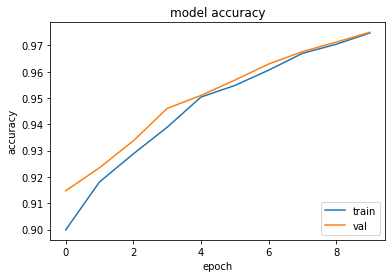

In [84]:
plot_accuracy(baseline_training)

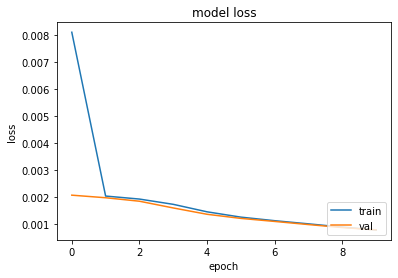

In [85]:
plot_loss(baseline_training)

In [ ]:
baseline_model.save_weights('models/baseline_model_weights.h5') #Save model

## Other models

#### Gru

In [87]:
def create_gru_model(units_gru, activation):
    gru_model = keras.Sequential()
    gru_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = True
                                ))
    gru_model.add(layers.Bidirectional(layers.GRU(units_gru, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    gru_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return gru_model

In [88]:
gru_model = create_gru_model(64, 'softmax')
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_4 (Bidirectio  (None, 249, 128)         44544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 249, 46)           5934      
                                                                 
Total params: 586,378
Trainable params: 586,378
Non-trainable params: 0
_________________________________________________________________


In [89]:
gru_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
gru_training = gru_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0202 - acc: 0.9098

In [ ]:
plot_accuracy(gru_model)

NameError: name 'gru_model' is not defined

In [ ]:
plot_loss(gru_model)

In [ ]:
gru_model.save_weights('models/gru_model_weights.h5') #Save model

#### Two LSTM layers

In [ ]:
def create_doubleLSTM_model(units_LSTM1, units_LSTM2, activation):
    doubleLSTM_model = keras.Sequential()
    doubleLSTM_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = True
                                ))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM1, return_sequences=True)))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM2, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubleLSTM_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubleLSTM_model

In [ ]:
doubleLSTM_model = create_doubleLSTM_model(64, 64, 'softmax')
doubleLSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_2 (Bidirectio  (None, 249, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 249, 128)         98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 249, 46)           5934      
                                                                 
Total params: 699,530
Trainable params: 699,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
doubleLSTM_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleLSTM_training = doubleLSTM_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 32s 348ms/step - loss: 0.0065 - mae: 0.0135 - acc: 0.9009
Epoch 2/10
75/75 [==============================] - 22s 297ms/step - loss: 0.0020 - mae: 0.0043 - acc: 0.9144
Epoch 3/10
75/75 [==============================] - 21s 284ms/step - loss: 0.0020 - mae: 0.0041 - acc: 0.9155
Epoch 4/10
75/75 [==============================] - 23s 296ms/step - loss: 0.0020 - mae: 0.0040 - acc: 0.9216
Epoch 5/10
75/75 [==============================] - 20s 270ms/step - loss: 0.0019 - mae: 0.0038 - acc: 0.9286
Epoch 6/10
75/75 [==============================] - 19s 250ms/step - loss: 0.0016 - mae: 0.0034 - acc: 0.9420
Epoch 7/10
75/75 [==============================] - 26s 344ms/step - loss: 0.0013 - mae: 0.0028 - acc: 0.9510
Epoch 8/10
75/75 [==============================] - 23s 303ms/step - loss: 0.0012 - mae: 0.0025 - acc: 0.9575
Epoch 9/10
75/75 [==============================] - 23s 304ms/step - loss: 0.0010 - mae: 0.0023 - acc: 0.9645
Epoch 10/1

In [ ]:
doubleLSTM_model.save_weights('models/doubleLSTM_model_weights.h5') #Save model

#### Two dense layers

In [ ]:
def create_doubledense_model(units_LSTM, units_dense, activation):
    doubledense_model = keras.Sequential()
    doubledense_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = True
                                ))
    doubledense_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    doubledense_model.add(layers.Dense(units_dense))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubledense_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubledense_model

In [ ]:
doubleDense_model = create_doubledense_model(64, 64, 'softmax')
doubleDense_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_4 (Bidirectio  (None, 249, 128)         58880     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 249, 64)           8256      
                                                                 
 dense_4 (Dense)             (None, 249, 46)           2990      
                                                                 
Total params: 606,026
Trainable params: 606,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
doubleDense_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleDense_training = doubleDense_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 14s 142ms/step - loss: 0.0072 - mae: 0.0147 - acc: 0.9040
Epoch 2/10
75/75 [==============================] - 9s 125ms/step - loss: 0.0020 - mae: 0.0041 - acc: 0.9173
Epoch 3/10
75/75 [==============================] - 9s 120ms/step - loss: 0.0019 - mae: 0.0039 - acc: 0.9304
Epoch 4/10
75/75 [==============================] - 10s 128ms/step - loss: 0.0015 - mae: 0.0032 - acc: 0.9454
Epoch 5/10
75/75 [==============================] - 11s 146ms/step - loss: 0.0012 - mae: 0.0026 - acc: 0.9556
Epoch 6/10
75/75 [==============================] - 11s 141ms/step - loss: 0.0011 - mae: 0.0023 - acc: 0.9624
Epoch 7/10
75/75 [==============================] - 9s 122ms/step - loss: 8.9452e-04 - mae: 0.0020 - acc: 0.9695
Epoch 8/10
75/75 [==============================] - 9s 124ms/step - loss: 7.5752e-04 - mae: 0.0017 - acc: 0.9752
Epoch 9/10
75/75 [==============================] - 10s 131ms/step - loss: 6.6340e-04 - mae: 0.0014 - acc: 0.9779
Ep

In [ ]:
doubleDense_model.save_weights('models/doubleDense_model_weights.h5') #Save model

In [80]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

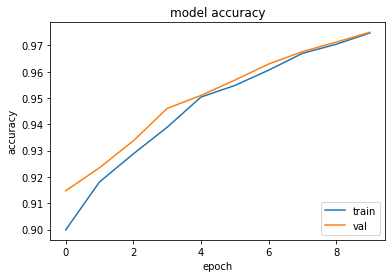

In [81]:
plot_accuracy(baseline_training)

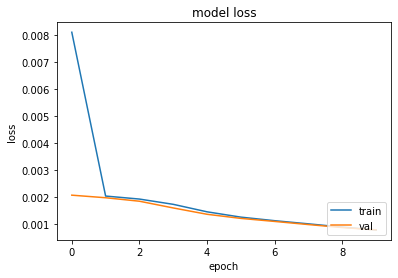

In [82]:
plot_loss(baseline_training)

## Predict